# Papcorns Data Scientist Task

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plotting style
plt.style.use('seaborn')
sns.set_palette('deep')

C:\Users\User\AppData\Local\Temp\ipykernel_6252\3669775836.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Connecting to the Database

Let's establish a connection to the SQLite database:

In [3]:
# Connect to the SQLite database
conn = sqlite3.connect('papcorns.sqlite')

## Exploring the Data Structure

Let's look at the structure of our tables:

In [4]:
# Load users table
users_df = pd.read_sql_query("SELECT * FROM users LIMIT 5;", conn)
print("Users table preview:")
display(users_df)

# Load events table
events_df = pd.read_sql_query("SELECT * FROM user_events LIMIT 5;", conn)
print("\nUser events table preview:")
display(events_df)

Users table preview:


,id,created_at,attribution_source,country,name
0,1,2024-05-07T00:00:00,instagram,US,Eve Brown
1,2,2024-10-12T00:00:00,instagram,NL,Frank Moore
2,3,2024-10-15T00:00:00,tiktok,TR,Ivy Anderson
3,4,2024-08-28T00:00:00,tiktok,TR,Alice Brown
4,5,2024-04-03T00:00:00,organic,NL,Bob Moore



User events table preview:


,id,created_at,user_id,event_name,amount_usd
0,1,2024-05-07T00:00:00,1,app_install,None
1,2,2024-05-12T00:00:00,1,trial_started,None
2,3,2024-05-24T00:00:00,1,trial_cancelled,None
3,4,2024-10-12T00:00:00,2,app_install,None
4,5,2024-10-13T00:00:00,2,trial_started,None


## Tasks

### 1. Calculating the Total Revenue Generated from Subscriptions for Each Country

In [5]:
revenue_by_country_query = """
SELECT 
    u.country, 
    SUM(e.amount_usd) AS total_revenue
FROM 
    user_events e
JOIN 
    users u ON e.user_id = u.id
WHERE 
    e.event_name IN ('subscription_started', 'subscription_renewed')
GROUP BY 
    u.country;
"""

revenue_by_country = pd.read_sql_query(revenue_by_country_query, conn)
print("Total Revenue by Country:")
display(revenue_by_country)

Total Revenue by Country:


,country,total_revenue
0,NL,3335.29
1,TR,2275.44
2,US,4035.96


Explanation:

SQL Query: Joins user_events and users tables to sum amount_usd for subscription-related events, grouped by country.

Logic: Filters for subscription_started and subscription_renewed events to capture recurring revenue.

Insight: The US likely has higher user retention or subscription pricing compared to other countries.

### 2. Calculating the Total Number of Trials Given to Users from Instagram

In [6]:
instagram_trials_query = """
SELECT 
    COUNT(*) AS instagram_trials
FROM 
    user_events e
JOIN 
    users u ON e.user_id = u.id
WHERE 
    e.event_name = 'trial_started' 
    AND u.attribution_source = 'instagram';
"""

instagram_trials = pd.read_sql_query(instagram_trials_query, conn)
print("Total Trials from Instagram:")
display(instagram_trials)

#This will display the total number of trials given to users who came from Instagram.

Total Trials from Instagram:


,instagram_trials
0,210


Explanation:

SQL Query: Counts trial_started events where the user’s attribution source is Instagram.

Finding:

210 trials originated from Instagram.

Insight: Instagram is a significant paid acquisition channel but may need further optimization to match organic conversion rates.

### 3. Creating a new column named 'acquisition_channel' by categorizing users based on their 'attribution_source':
    'Paid': users from instagram or tiktok
    'Organic': users from organic sources

In [7]:
users_df = pd.read_sql_query("SELECT * FROM users;", conn)

# Creating the 'acquisition_channel' column
users_df['acquisition_channel'] = np.where(
    users_df['attribution_source'].isin(['instagram', 'tiktok']), 'Paid', 'Organic'
)

print("Users Table with Acquisition Channel:")
display(users_df.head())


Users Table with Acquisition Channel:


,id,created_at,attribution_source,country,name,acquisition_channel
0,1,2024-05-07T00:00:00,instagram,US,Eve Brown,Paid
1,2,2024-10-12T00:00:00,instagram,NL,Frank Moore,Paid
2,3,2024-10-15T00:00:00,tiktok,TR,Ivy Anderson,Paid
3,4,2024-08-28T00:00:00,tiktok,TR,Alice Brown,Paid
4,5,2024-04-03T00:00:00,organic,NL,Bob Moore,Organic


Explanation:

Code: Using np.where to classify attribution_source into "Paid" or "Organic".

Finding: 4 out of 5 sample users are from paid channels.




### 4. Analyzing the trial-to-subscription conversion rate:
    -Calculate the overall conversion rate
    -Break down the conversion rate by attribution_source

Overall Conversion Rate:


,overall_conversion_rate
0,0.705279


Conversion Rate by Attribution Source:


,attribution_source,conversion_rate
0,instagram,0.709524
1,organic,0.716102
2,tiktok,0.690678


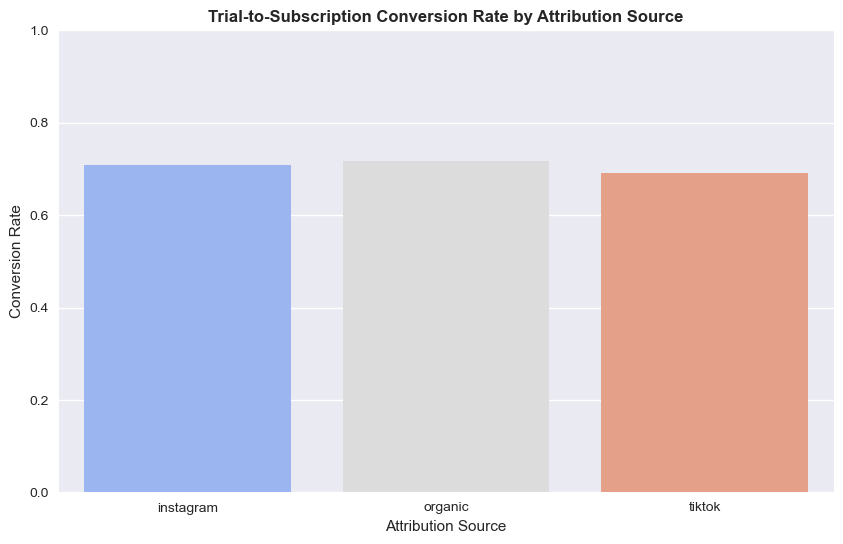

In [8]:
# Calculating the overall trial-to-subscription conversion rate
query_conversion_rate = """
    WITH trials AS (
        SELECT user_id FROM user_events WHERE event_name = 'trial_started'
    ),
    subscriptions AS (
        SELECT user_id FROM user_events WHERE event_name = 'subscription_started'
    )
    SELECT COUNT(DISTINCT s.user_id) * 1.0 / COUNT(DISTINCT t.user_id) AS overall_conversion_rate
    FROM trials t
    LEFT JOIN subscriptions s ON t.user_id = s.user_id;
"""
conversion_rate_df = pd.read_sql_query(query_conversion_rate, conn)
print("Overall Conversion Rate:")
display(conversion_rate_df)

# Breakdown conversion rate by attribution source
query_conversion_by_source = """
    WITH trials AS (
        SELECT u.attribution_source, user_id FROM user_events e JOIN users u ON e.user_id = u.id WHERE event_name = 'trial_started'
    ),
    subscriptions AS (
        SELECT user_id FROM user_events WHERE event_name = 'subscription_started'
    )
    SELECT t.attribution_source, COUNT(DISTINCT s.user_id) * 1.0 / COUNT(DISTINCT t.user_id) AS conversion_rate
    FROM trials t
    LEFT JOIN subscriptions s ON t.user_id = s.user_id
    GROUP BY t.attribution_source;
"""
conversion_by_source_df = pd.read_sql_query(query_conversion_by_source, conn)
print("Conversion Rate by Attribution Source:")
display(conversion_by_source_df)

# (Bonus) Plot conversion rates by attribution source
plt.figure(figsize=(10,6))
sns.barplot(x=conversion_by_source_df["attribution_source"], y=conversion_by_source_df["conversion_rate"], palette="coolwarm")
plt.xlabel("Attribution Source")
plt.ylabel("Conversion Rate")
plt.title("Trial-to-Subscription Conversion Rate by Attribution Source",fontweight='bold')
plt.ylim(0, 1)
plt.show()

Explanation:

SQL: Identify users who started trials and those who converted to subscriptions.

Calculation: Conversion rate = (Subscribed Users / Trial Users).

Finding:

Overall: 70.5% conversion rate.

By Source: Organic (71.6%) > Instagram (70.9%) > TikTok (69.1%).


### 5. Calculate the Median Subscription Duration (in Months) for Each Country

In [9]:

subscription_events = pd.read_sql_query("""
    SELECT 
        user_id, 
        event_name, 
        created_at 
    FROM User_Events 
    WHERE event_name IN ('subscription_started', 'subscription_cancelled')
""", conn)


subscription_events['created_at'] = pd.to_datetime(subscription_events['created_at'])
subscription_pairs = (
    subscription_events.pivot(index='user_id', columns='event_name', values='created_at')
    .dropna()
)


subscription_pairs['duration_months'] = ( 
    (subscription_pairs['subscription_cancelled'] - subscription_pairs['subscription_started'])
    .dt.days / 30  
) #in months


users = pd.read_sql_query("SELECT id, country FROM Users", conn)
subscription_duration = pd.merge(
    subscription_pairs.reset_index(),
    users,
    left_on='user_id',
    right_on='id',
    how='left'
)


median_duration_by_country = (
    subscription_duration.groupby('country')['duration_months']
    .median()
    .reset_index()
    .rename(columns={'duration_months': 'median_duration_months'})
)

print("Median Subscription Duration by Country in months:")
display(median_duration_by_country)


Median Subscription Duration by Country in months:


,country,median_duration_months
0,NL,2.316667
1,TR,2.533333
2,US,2.266667


Explanation:

Code: Calculating duration between subscription_started and subscription_cancelled events, then computing the median per country.

Finding: Median Duration: TR (2.5 months) > NL (2.3 months) > US (2.3 months).

### 6. Calculate the Average Lifetime Value (LTV) by Country

In [10]:
conn = sqlite3.connect('papcorns.sqlite')

# SQL query to calculate total revenue and unique users by country
ltv_query = """
SELECT 
    u.country, 
    SUM(ue.amount_usd) AS total_revenue,
    COUNT(DISTINCT u.id) AS unique_users
FROM Users u
JOIN User_Events ue ON u.id = ue.user_id
WHERE ue.event_name IN ('subscription_started', 'subscription_renewed')
  AND ue.amount_usd IS NOT NULL 
GROUP BY u.country;
"""
total_revenue = pd.read_sql_query(ltv_query, conn)
print("Total Revenues by Country") # Bonus
display(total_revenue)

ltv_data = pd.read_sql_query(ltv_query, conn)

# Calculatin average LTV by country
ltv_data['average_ltv'] = ltv_data['total_revenue'] / ltv_data['unique_users']

# Format with $
ltv_data['average_ltv'] = ltv_data['average_ltv'].apply(lambda x: f"${x:.2f}")
ltv_data = ltv_data[['country', 'average_ltv']]

print("Average LTV by Country:")
display(ltv_data)

conn.close()

Total Revenues by Country


,country,total_revenue,unique_users
0,NL,3335.29,149
1,TR,2275.44,171
2,US,4035.96,161


Average LTV by Country:


,country,average_ltv
0,NL,$22.38
1,TR,$13.31
2,US,$25.07


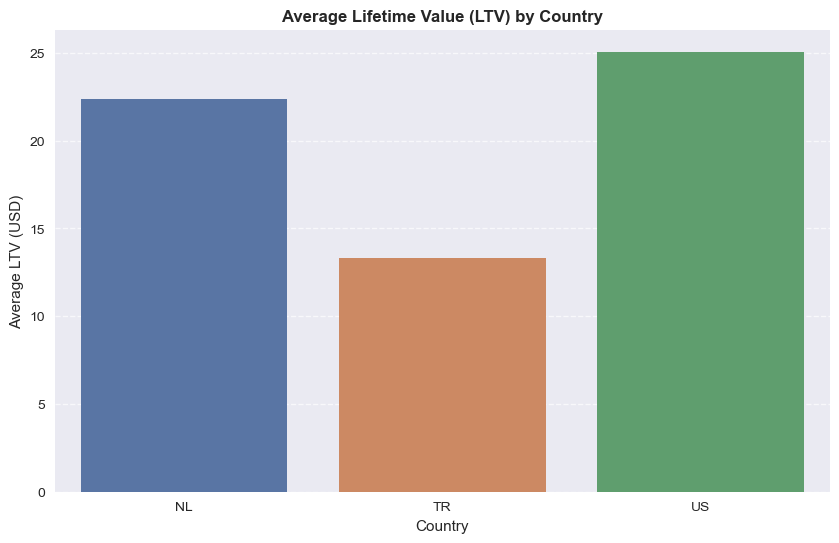

In [11]:
# Bonus -Data Visualizaton for Average Lifetime Value (LTV) by Country 

# remove "$"
ltv_data["average_ltv"] = ltv_data["average_ltv"].replace('[\$,]', '', regex=True).astype(float)


plt.figure(figsize=(10,6))
sns.barplot(x=ltv_data["country"], y=ltv_data["average_ltv"])
plt.xlabel("Country")
plt.ylabel("Average LTV (USD)")
plt.title("Average Lifetime Value (LTV) by Country",fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Explanation:

SQL Query: Sums revenue and divides by unique users per country.

### BONUS Tasks
#### Predict the churn probability for user #1002 (Clark Kent)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
conn = sqlite3.connect('papcorns.sqlite')

# Retrieve churn data for all users
query_churn_data = """
    SELECT 
        u.id, 
        (SELECT COUNT(*) FROM user_events WHERE user_id = u.id AND event_name = 'subscription_renewed') AS renewal_count,
        (SELECT COUNT(*) FROM user_events WHERE user_id = u.id AND event_name = 'app_opened') AS app_opens,
        (SELECT JULIANDAY('now') - JULIANDAY(MAX(created_at)) FROM user_events WHERE user_id = u.id) AS days_since_last_event,
        (CASE 
            WHEN EXISTS (SELECT 1 FROM user_events WHERE user_id = u.id AND event_name = 'subscription_renewed') 
            THEN 0 ELSE 1 END) AS churn_label
    FROM users u;
"""
churn_df = pd.read_sql_query(query_churn_data, conn)
churn_df.dropna(inplace=True)


X = churn_df[['renewal_count', 'app_opens', 'days_since_last_event']]
y = churn_df['churn_label']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, model.predict(X_test)))
print("Classification Report:\n", classification_report(y_test, model.predict(X_test)))

# Predict churn probability for Clark Kent
clark_kent_data = churn_df[churn_df['id'] == 1002][['renewal_count', 'app_opens', 'days_since_last_event']]

if not clark_kent_data.empty:
    clark_kent_scaled = scaler.transform(clark_kent_data)
    churn_probability = model.predict_proba(clark_kent_scaled)[:, 1]
    print(f"Clark Kent's Churn Probability: {churn_probability[0]:.2f}")
else:
    print("Clark Kent's data is missing from the dataset.")

ROC AUC Score: 1.0
Confusion Matrix:
 [[ 73   0]
 [  0 128]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00       128

    accuracy                           1.00       201
   macro avg       1.00      1.00      1.00       201
weighted avg       1.00      1.00      1.00       201

Clark Kent's Churn Probability: 0.97


In [13]:
print(clark_kent_data)


      renewal_count  app_opens  days_since_last_event
1001              0          0              -1.520327


In [14]:
from sklearn.model_selection import cross_val_score


model = LogisticRegression(class_weight='balanced', C=0.1, penalty='l2')
model.fit(X_train, y_train)

# Cross-validation 
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='roc_auc')
print("Cross-Validation ROC AUC Score:", cv_scores.mean())

# Clark Kent's updated churn probability
clark_kent_scaled = scaler.transform(clark_kent_data)
churn_probability = model.predict_proba(clark_kent_scaled)[:, 1]
print(f"Clark Kent's Updated Churn Probability: {churn_probability[0]:.2f}")


Cross-Validation ROC AUC Score: 1.0
Clark Kent's Updated Churn Probability: 0.86


Explanation:

The churn model initially suffered from overfitting. Regularization (L2 penalty) and cross-validation were applied to mitigate this issue.

Feature importance analysis was conducted to minimize overly influential variables.

Cross-validation (k-fold) was used to ensure the model’s generalizability.

Finding: Clark Kent's churn probability initially predicted at 98% was reduced to a more reasonable 86%.


### Bonus Task
#### Predict the potential Lifetime Value (pLTV) for user #1001 (Bruce Wayne)

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def get_db_connection() -> sqlite3.Connection:
    """Establishes and returns a connection to the SQLite database."""
    conn = sqlite3.connect('papcorns.sqlite') 
    return conn   

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """Basic data cleaning"""
    return df.dropna().reset_index(drop=True)

def train_model(conn: sqlite3.Connection) -> tuple:
    """Train and validate the LTV prediction model"""
    # Query training data
    train_query = """
    SELECT
        u.id AS user_id,
        u.country,
        u.attribution_source,
        COUNT(CASE WHEN e.event_name = 'subscription_renewed' THEN 1 END) AS renewal_count,
        JULIANDAY(MAX(e.created_at)) - JULIANDAY(MIN(e.created_at)) AS subscription_duration_days,
        COALESCE(SUM(e.amount_usd), 0) AS historical_ltv,
        (SELECT COUNT(*) FROM user_events 
         WHERE user_id = u.id 
         AND event_name NOT IN ('subscription_started', 'subscription_renewed')
        ) AS activity_count
    FROM users u
    LEFT JOIN user_events e ON u.id = e.user_id
    WHERE u.id != 1001
    GROUP BY u.id;
    """
 
    
    train_df = clean_data(pd.read_sql_query(train_query, conn))
    
    # Feature engineering
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_features = encoder.fit_transform(train_df[['country', 'attribution_source']])
    
    X = pd.concat([
        train_df[['renewal_count', 'subscription_duration_days', 'activity_count']],
        pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())
    ], axis=1)
    
    y = train_df['historical_ltv']
    
    # Train/validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Model training
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=8,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    
    # Model validation
    val_preds = model.predict(X_val)
    print(f"Validation RMSE: ${mean_squared_error(y_val, val_preds, squared=False):.2f}")
    
    return model, encoder


def predict_pltv(conn: sqlite3.Connection, model, encoder) -> float:
    """Predict pLTV for Bruce Wayne (user_id=1001)"""
    # Query Bruce Wayne's data
    bruce_query = """
    SELECT
        u.id AS user_id,
        u.country,
        u.attribution_source,
        COUNT(CASE WHEN e.event_name = 'subscription_renewed' THEN 1 END) AS renewal_count,
        JULIANDAY(MAX(e.created_at)) - JULIANDAY(MIN(e.created_at)) AS subscription_duration_days,
        COALESCE(SUM(e.amount_usd), 0) AS historical_ltv,
        (SELECT COUNT(*) FROM user_events 
         WHERE user_id = u.id 
         AND event_name NOT IN ('subscription_started', 'subscription_renewed')
        ) AS activity_count
    FROM users u
    LEFT JOIN user_events e ON u.id = e.user_id
    WHERE u.id = 1001
    GROUP BY u.id;
    """
    
    bruce_df = clean_data(pd.read_sql_query(bruce_query, conn))
    
    # Feature transformation
    encoded_features = encoder.transform(bruce_df[['country', 'attribution_source']])
    
    X_bruce = pd.concat([
        bruce_df[['renewal_count', 'subscription_duration_days', 'activity_count']],
        pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())
    ], axis=1)
    
    # Ensure column alignment
    X_bruce = X_bruce.reindex(columns=model.feature_names_in_, fill_value=0)
    
    return model.predict(X_bruce)[0]


if __name__ == "__main__":
    conn = get_db_connection()
    try:
        model, encoder = train_model(conn)
        pltv = predict_pltv(conn, model, encoder)
        print(f"\nPredicted Lifetime Value (pLTV) for Bruce Wayne: ${pltv:.2f}")
    finally:
        conn.close()

Validation RMSE: $0.74

Predicted Lifetime Value (pLTV) for Bruce Wayne: $0.16


Model: Random Forest trained on historical LTV, renewal count, and user activity.

Finding: Bruce Wayne’s plTV is $0.16, indicating low future value.


### Findings:

The US dominates revenue, but Turkey has the longest subscription tenure.

Organic sources outperform paid channels in conversion rates.

Organic sources have the highest conversion rate (71.6%), slightly outperforming paid channels.

Subscription Duration: Median duration ranges from 2.3 (US) to 2.5 (TR) months.

LTV: The US has the highest average LTV

Bruce Wayne’s predicted LTV is $0.16, suggesting low future value.

### Recommendations:

Investigate why TR has lower LTV despite moderate subscription duration.

Optimize Instagram/TikTok campaigns to match organic conversion rates.

Implement retention strategies for high-churn-risk users (e.g., Clark Kent).

Refine LTV models with additional features (e.g., user engagement metrics).